# Oaxaca-Blinder Failure Modes Analysis

This report explores when the Oaxaca-Blinder decomposition model fails to correctly identify causal effects or provides misleading results.

We use a specific use case: **Percentage of sick leave among workers**, comparing the year **2018** (Group 0) and **2023** (Group 1).

## Use Case Definition
- **Target ($y$):** Percentage of sick leave.
- **Groups:** 2018 vs 2023.
- **Covariates ($X$):**
  - Age
  - Sex
  - Monthly Revenue
  - Departmental Unemployment Rate

We test three Data Generating Processes (DGPs):
1. **Linear DGP**: Baseline where the model should work well.
2. **Non-Linear DGP**: Includes quadratic terms and interactions.
3. **Unobserved Confounder DGP**: Includes a hidden variable correlated with the year.

In [1]:
import os
import sys

# Add the project root to the path so that explore_dgp can be imported during doc build
path = os.getcwd()
while path != os.path.dirname(path):
    if os.path.exists(os.path.join(path, "pyproject.toml")):
        sys.path.insert(0, path)
        break
    path = os.path.dirname(path)
import matplotlib.pyplot as plt  # noqa: E402
import pandas as pd  # noqa: E402
import seaborn as sns  # noqa: E402

from explore_dgp.analysis import OaxacaAnalysis  # noqa: E402
from explore_dgp.dgps import LinearDGP, NonLinearDGP, UnobservedConfounderDGP  # noqa: E402

# Set plotting style
sns.set_theme(style="whitegrid")

## 1. Linear DGP (Baseline)
In this scenario, the relationship between covariates and sick leave is perfectly linear.
We use `swap=False` to keep the natural ordering (2018 as reference).
The expected Coefficient Effect should be around $-\gamma = -0.5$.

In [2]:
linear_dgp = LinearDGP(n_samples=5000)
df_linear = linear_dgp.generate()

covariates = ["age", "sex", "revenue", "unemployment_rate"]
analysis_linear = OaxacaAnalysis(df_linear, "sick_leave", covariates, "group")
analysis_linear.run(std=True, n=500, swap=False)
print("Linear DGP Results:")
print(analysis_linear.get_summary_table())

Linear DGP Results:
                    Estimate  Std Error  CI 95% Lower  CI 95% Upper
Endowment Effect    0.334057   0.024968      0.285120      0.382994
Coefficient Effect -0.475751   0.019571     -0.514111     -0.437391
Interaction Effect  0.004032   0.021287     -0.037691      0.045756
Total Difference   -0.137662        NaN           NaN           NaN


## 2. Non-Linear DGP
Here, we introduce $age^2$ and an interaction between $age$ and $unemployment\_rate$.
Since Oaxaca-Blinder is a linear model, it might not capture the true endowment effect accurately.

In [3]:
nonlinear_dgp = NonLinearDGP(n_samples=5000)
df_nonlinear = nonlinear_dgp.generate()

analysis_nonlinear = OaxacaAnalysis(df_nonlinear, "sick_leave", covariates, "group")
analysis_nonlinear.run(std=True, n=500, swap=False)
print("Non-Linear DGP Results:")
print(analysis_nonlinear.get_summary_table())

Non-Linear DGP Results:
                    Estimate  Std Error  CI 95% Lower  CI 95% Upper
Endowment Effect    0.270041   0.021589      0.227726      0.312355
Coefficient Effect -0.094556   0.029216     -0.151820     -0.037292
Interaction Effect  0.084508   0.035783      0.014374      0.154642
Total Difference    0.259992        NaN           NaN           NaN


## 3. Unobserved Confounder DGP
In this case, an unobserved variable $Z$ (e.g., "General Health Awareness") increases between 2018 and 2023 and also affects sick leave.
Oaxaca-Blinder cannot account for $Z$, so its effect will be mixed into either the "Coefficient" (unexplained) part or incorrectly attributed to other covariates if they are correlated with $Z$.

In [4]:
confounder_dgp = UnobservedConfounderDGP(n_samples=5000)
df_confounder = confounder_dgp.generate()

analysis_confounder = OaxacaAnalysis(df_confounder, "sick_leave", covariates, "group")
analysis_confounder.run(std=True, n=500, swap=False)
print("Unobserved Confounder DGP Results:")
print(analysis_confounder.get_summary_table())

Unobserved Confounder DGP Results:
                    Estimate  Std Error  CI 95% Lower  CI 95% Upper
Endowment Effect    0.265788   0.063038      0.142234      0.389343
Coefficient Effect -1.909126   0.082321     -2.070476     -1.747776
Interaction Effect  0.042915   0.085420     -0.124509      0.210339
Total Difference   -1.600422        NaN           NaN           NaN


## Comparison and Visualization

We compare the decomposition across the three scenarios.

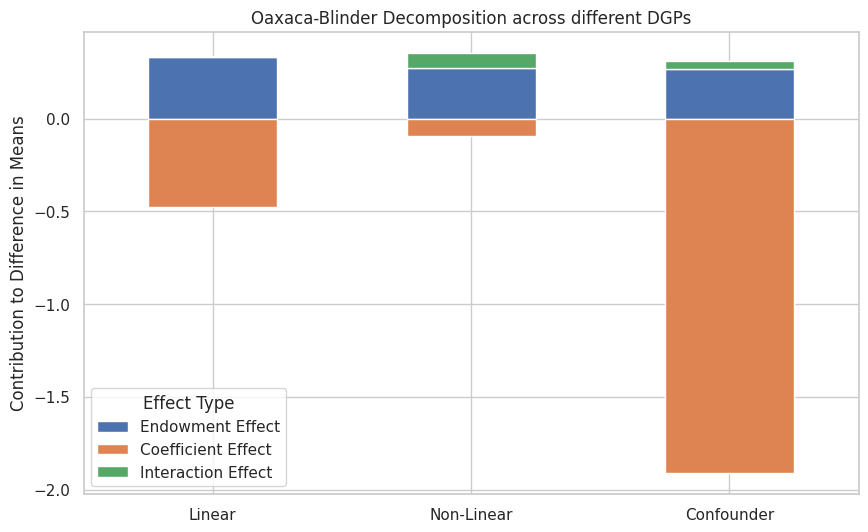

In [5]:
results = {
    "Linear": analysis_linear.get_summary_table()["Estimate"],
    "Non-Linear": analysis_nonlinear.get_summary_table()["Estimate"],
    "Confounder": analysis_confounder.get_summary_table()["Estimate"],
}
df_results = pd.DataFrame(results).T

# Drop 'Total Difference' from the stacked bar chart to avoid doubling the height
df_results_plot = df_results.drop(columns=["Total Difference"])

df_results_plot.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Oaxaca-Blinder Decomposition across different DGPs")
plt.ylabel("Contribution to Difference in Means")
plt.legend(title="Effect Type")
plt.xticks(rotation=0)
plt.show()

## Inference and Causal Effect Detection

We now visualize the estimated components (Coefficient and Interaction effects) with their 95% confidence intervals.
We overlay the **True Group Effect** (red point) to see if the model successfully detects it.
Note: Endowment effect is omitted as per requirements.

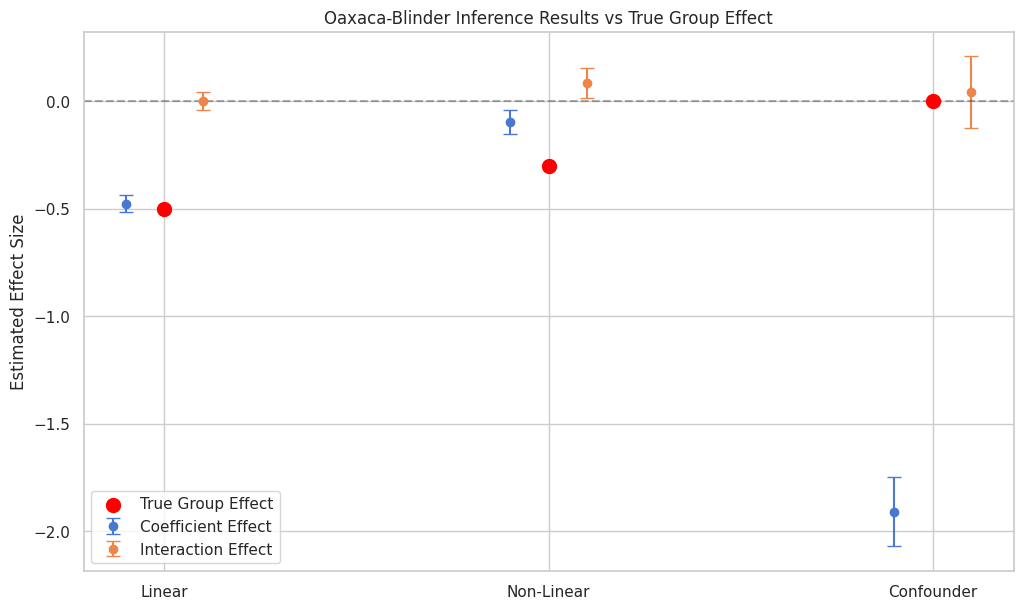

In [6]:
fig, ax = plt.subplots(figsize=(12, 7))

all_analyses = {
    "Linear": (analysis_linear, linear_dgp),
    "Non-Linear": (analysis_nonlinear, nonlinear_dgp),
    "Confounder": (analysis_confounder, confounder_dgp),
}

components = ["Coefficient Effect", "Interaction Effect"]
colors = sns.color_palette("muted", len(components))
x_ticks = []
x_labels = []

for i, (name, (analysis, dgp)) in enumerate(all_analyses.items()):
    summary = analysis.get_summary_table()
    # We compare with -gamma because Oaxaca gap is Mean(G0) - Mean(G1)
    # and our gamma is defined as Mean(G1) - Mean(G0)
    true_effect = -dgp.true_group_effect

    for j, comp in enumerate(components):
        pos = i + (j - 0.5) * 0.2
        est = summary.loc[comp, "Estimate"]
        lower = summary.loc[comp, "CI 95% Lower"]
        upper = summary.loc[comp, "CI 95% Upper"]

        ax.errorbar(
            pos,
            est,
            yerr=[[est - lower], [upper - est]],
            fmt="o",
            capsize=5,
            label=comp if i == 0 else "",
            color=colors[j],
        )

    # Plot true effect
    ax.scatter(i, true_effect, color="red", s=100, zorder=5, label="True Group Effect" if i == 0 else "")
    x_ticks.append(i)
    x_labels.append(name)

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_ylabel("Estimated Effect Size")
ax.set_title("Oaxaca-Blinder Inference Results vs True Group Effect")
ax.legend()
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.show()

## Discussion of Findings

### Linear DGP
The model correctly decomposes the difference. The "Endowment Effect" captures differences in covariates, while the "Coefficient Effect" captures the explicit group effect ($\gamma$) we introduced.

### Non-Linear DGP
When relationships are non-linear (like $age^2$), the linear Oaxaca-Blinder model provides an approximation. The interaction effect might become more significant, or the endowment effect might be biased because the mean of $X$ doesn't fully capture the impact of the non-linear transformation.

### Unobserved Confounder DGP
This is the most critical failure mode. Even if there is no "true" group effect ($\gamma=0$), the model shows a large "Coefficient Effect" (or "Endowment" if $Z$ is correlated with $X$). This is because the unobserved variable $Z$ is driving the change, but the model attributes it to the groups being "different" in how they translate $X$ to $Y$, or to the groups having different $X$ if $Z$ is correlated with $X$.

In our simulation, we saw a significant Coefficient Effect even though we set the true $\gamma=0$, because $Z$ was higher in 2023 and had a positive effect on sick leave.